In [1]:
import math
import cv2 as cv
import numpy as np
import pandas as pd
from glob import glob
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse


# ------------------ #
from tensorflow.keras import models, Sequential
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Balanceacc

from models import efficientNetV2B0_model, efficientNetV2B3_model
from config import efficientNet_config
from sklearn.utils import shuffle

from utils import plt_heatmap, plt_roccurve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc


import os
# 使用第一張 GPU 卡
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

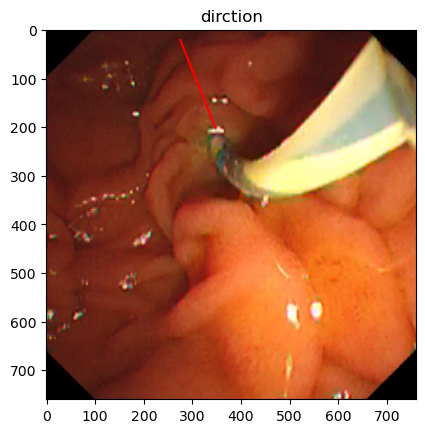

In [2]:
base_x = 1020
base_y = 160
img    = cv.imread('../dataset/temp_img/000140.png')
RGBimg = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.plot([1295-base_x, 1367-base_x], [181-base_y, 361-base_y],color="red")
plt.imshow(RGBimg)
plt.title('dirction')
plt.show()

# Canny 邊緣偵測

In [3]:
# def img_precessing(img, medianblur_kernel=21, canny_threshold1=5, canny_threshold2=40):
#     img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)                     # 轉成灰階
#     img_blur = cv.medianBlur(img_gray, medianblur_kernel)              # median blur 
#     # img_blur = img_gray                                                # no median blur 
#     img_edges= cv.Canny(img_blur, canny_threshold1, canny_threshold2)  # canny

#     return img_gray, img_blur, img_edges

In [4]:
# def Get_canny_angles(img_paths, medianblur_kernel=21, canny_threshold1=5, canny_threshold2=40):
#     canny_pred_angles=[]

#     for img_path in img_paths:
#         img_name = img_path.split("/")[-1]
#         img      = cv.imread(img_path)

#         img_gray, blur, edges = img_precessing(img, medianblur_kernel, canny_threshold1, canny_threshold2)
#         print(img_name)
#         ###############
#         cnt, hierarchy = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

#         ###### 找全部的輪廓出來畫
#         allcnt=[]
#         for c in cnt:
#             allcnt.extend(c.tolist())
#         allcnt = np.array(allcnt)   # 有可能找不到輪廓!!
#         if len(allcnt) != 0:
            
#             ####### 找出橢圓
#             img_elli = img.copy()
#             ellipse = cv.fitEllipseAMS(allcnt)  # fit出橢圓
#             # cv.ellipse(img_elli, ellipse, (0,0,255), 3)
            
#             ####### 找出角度(11點鐘方向)
#             img_11=img.copy()
#             (xc, yc), (width, height), angle = ellipse     # (xc,yc):橢圓中心點 (width, height):橢圓寬長
#             print("angle= ", int(angle))
            
#             if angle>90:  # 一開始的angle是比較長短邊的角度
#                 normal_angle = 360-angle-60
#                 print('normal angle=', normal_angle)
                

#                 ######################################## 處理特殊角度(150~180) ###############################################
#                 if normal_angle > 150 and normal_angle <=180:   
#                     normal_angle = normal_angle - 30
#                     canny_pred_angles.append((img_name, normal_angle))
#                     rmajor = height / 2
#                     xtop0  = xc + math.cos(math.radians(angle+120)) * rmajor
#                     ytop0  = yc + math.sin(math.radians(angle+120)) * rmajor
#                     rmajor = height / 2
#                     xtop11 = xc + math.cos(math.radians(angle+90)) * rmajor
#                     ytop11 = yc + math.sin(math.radians(angle+90)) * rmajor
#                     rminor = width / 2
#                     xtop = xc + math.cos(math.radians(angle+30)) * rminor
#                     ytop = yc + math.sin(math.radians(angle+30)) * rminor
#                     ellipse_info = Ellipse(xy=(xc, yc), width=width, height=height, angle=angle+30, edgecolor='b', fc='None', lw=2, linestyle='dotted')
#                 ######################################## 處理特殊角度(180~) ################################################
#                 elif normal_angle > 180:                         
#                     normal_angle = normal_angle - 60
#                     canny_pred_angles.append((img_name, normal_angle))
#                     rmajor = height / 2
#                     xtop0  = xc + math.cos(math.radians(angle+150)) * rmajor
#                     ytop0  = yc + math.sin(math.radians(angle+150)) * rmajor
#                     rmajor = height / 2
#                     xtop11 = xc + math.cos(math.radians(angle+120)) * rmajor
#                     ytop11 = yc + math.sin(math.radians(angle+120)) * rmajor
#                     rminor = width / 2
#                     xtop = xc + math.cos(math.radians(angle+60)) * rminor
#                     ytop = yc + math.sin(math.radians(angle+60)) * rminor
#                     ellipse_info = Ellipse(xy=(xc, yc), width=width, height=height, angle=angle+60, edgecolor='b', fc='None', lw=2, linestyle='dotted')
#                 ######################################## 正常角度(0~150) ################################################
#                 else:
#                     canny_pred_angles.append((img_name, normal_angle))
#                     rmajor = height / 2
#                     xtop0  = xc + math.cos(math.radians(angle+90)) * rmajor
#                     ytop0  = yc + math.sin(math.radians(angle+90)) * rmajor
#                     rmajor = height / 2
#                     xtop11 = xc + math.cos(math.radians(angle+60)) * rmajor
#                     ytop11 = yc + math.sin(math.radians(angle+60)) * rmajor
#                     rminor = width / 2
#                     xtop = xc + math.cos(math.radians(angle)) * rminor
#                     ytop = yc + math.sin(math.radians(angle)) * rminor
#                     ellipse_info = Ellipse(xy=(xc, yc), width=width, height=height, angle=angle, edgecolor='b', fc='None', lw=2, linestyle='dotted')

#                 print('new normal angle=', normal_angle)
#                 cv.line(img_11, (int(xtop0), int(ytop0)), (int(xc), int(yc)), (0, 0, 255), 1)
#                 cv.line(img_11, (int(xtop11), int(ytop11)), (int(xc), int(yc)), (128, 0, 0), 3)
#                 cv.line(img_11, (int(xtop), int(ytop)), (int(xc), int(yc)), (0, 0, 255), 1)
                


#             if angle<90:
#                 normal_angle = 180-angle-60
#                 print('normal angle=', normal_angle)
                

#                 ######################################## 處理特殊角度(0~30) ###############################################  
#                 if normal_angle > 0 and normal_angle <= 30:   
#                     normal_angle = normal_angle + 60                            ## !!!!!!!!!!!!!
#                     canny_pred_angles.append((img_name, normal_angle))
#                     rmajor = height / 2
#                     xtop0  = xc + math.cos(math.radians(angle+210)) * rmajor
#                     ytop0  = yc + math.sin(math.radians(angle+210)) * rmajor
#                     rmajor = height / 2
#                     xtop11 = xc + math.cos(math.radians(angle+180)) * rmajor
#                     ytop11 = yc + math.sin(math.radians(angle+180)) * rmajor
#                     rminor = width / 2
#                     xtop = xc + math.cos(math.radians(angle+120)) * rminor
#                     ytop = yc + math.sin(math.radians(angle+120)) * rminor
#                     ellipse_info = Ellipse(xy=(xc, yc), width=width, height=height, angle=angle+120, edgecolor='b', fc='None', lw=2, linestyle='dotted')
#                 ######################################## 處理特殊角度(30~60) ###############################################
#                 elif normal_angle > 30 and normal_angle <= 60:   
#                     normal_angle = normal_angle + 30                            ## !!!!!!!!!!!!!!
#                     canny_pred_angles.append((img_name, normal_angle))
#                     rmajor = height / 2
#                     xtop0  = xc + math.cos(math.radians(angle+240)) * rmajor
#                     ytop0  = yc + math.sin(math.radians(angle+240)) * rmajor
#                     rmajor = height / 2
#                     xtop11 = xc + math.cos(math.radians(angle+210)) * rmajor
#                     ytop11 = yc + math.sin(math.radians(angle+210)) * rmajor
#                     rminor = width / 2
#                     xtop = xc + math.cos(math.radians(angle+150)) * rminor
#                     ytop = yc + math.sin(math.radians(angle+150)) * rminor
#                     ellipse_info = Ellipse(xy=(xc, yc), width=width, height=height, angle=angle+150, edgecolor='b', fc='None', lw=2, linestyle='dotted')
#                 ######################################## 正常角度(0~150) ################################################
#                 else:
#                     canny_pred_angles.append((img_name, normal_angle))
#                     rmajor = height / 2
#                     xtop0  = xc + math.cos(math.radians(angle+270)) * rmajor
#                     ytop0  = yc + math.sin(math.radians(angle+270)) * rmajor
#                     rmajor = height / 2
#                     xtop11 = xc + math.cos(math.radians(angle+240)) * rmajor
#                     ytop11 = yc + math.sin(math.radians(angle+240)) * rmajor
#                     rminor = width / 2
#                     xtop = xc + math.cos(math.radians(angle+180)) * rminor
#                     ytop = yc + math.sin(math.radians(angle+180)) * rminor
#                     ellipse_info = Ellipse(xy=(xc, yc), width=width, height=height, angle=angle+180, edgecolor='b', fc='None', lw=2, linestyle='dotted')
                
#                 print('new normal angle=', normal_angle)
#                 cv.line(img_11, (int(xtop0), int(ytop0)), (int(xc), int(yc)), (0, 0, 255), 1)
#                 cv.line(img_11, (int(xtop11), int(ytop11)), (int(xc), int(yc)), (128, 0, 0), 3)
#                 cv.line(img_11, (int(xtop), int(ytop)), (int(xc), int(yc)), (0, 0, 255), 1)

            
#             ################# plot img
#             # plt.figure()
#             # f, axarr = plt.subplots(1, 5,figsize=(20,8)) 
#             # axarr[0].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
#             # axarr[1].imshow(cv.cvtColor(img_gray, cv.COLOR_BGR2RGB))
#             # axarr[2].imshow(cv.cvtColor(blur, cv.COLOR_BGR2RGB))
#             # axarr[3].imshow(cv.cvtColor(edges, cv.COLOR_BGR2RGB))
#             # axarr[4].imshow(cv.cvtColor(img_11, cv.COLOR_BGR2RGB))
#             # plt.show()
#             ##################### save img
#             # plt.imsave("../dataset/training_dataset/img/train/Crop_Gray/{}".format(img_name), cv.cvtColor(img_gray, cv.COLOR_BGR2RGB))       # !!!!!!!!!!!!
#             # plt.imsave("../dataset/training_dataset/img/train/Crop_MedianBlur/{}".format(img_name), cv.cvtColor(blur, cv.COLOR_BGR2RGB))     # !!!!!!!!!!!!
#             # plt.imsave("../dataset/training_dataset/img/train/Crop_CannyEdge/{}".format(img_name), cv.cvtColor(edges, cv.COLOR_BGR2RGB))     # !!!!!!!!!!!!
#             # plt.imsave("../dataset/result_img/canny_traindata_direction_result/canny_{}".format(img_name), cv.cvtColor(img_11, cv.COLOR_BGR2RGB))  # !!!!!!!!!!!!

#             # plt.figure()
#             # f, ax = plt.subplots(figsize=(3,4)) 
#             # ax.add_artist(ellipse_info)  # 橢圓
#             # ax.set_axis_off()
#             # plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
#             # plt.savefig("../dataset/result_img/canny_traindata_ellipse_result/ellipse_{}".format(img_name),bbox_inches='tight', pad_inches=0)    # !!!!!!!!!!!!
#             # plt.close(f)

#     return canny_pred_angles

In [5]:
# def Get_MAE(canny_pred_angles, true_df):
#     canny_pred_df = pd.DataFrame(canny_pred_angles,columns=['img_name','canny_angle'])
#     # print(cannytes_df.shape)

#     ''' true data left join '''
#     true_df_all = true_df.merge(canny_pred_df, on=['img_name'], how='left')

#     true_df_all['angle_error'] = abs(true_df_all['old_angle']-true_df_all['canny_angle'])

#     print("-----------------------------")
#     mae = round(true_df_all['angle_error'].mean(),3)
#     print("mean angle error= ", mae)
    
#     pmae = mae/180
#     print("percentage mean angle error= ", pmae)
#     return true_df_all, mae, pmae

In [6]:
# train_img_paths     = sorted(glob('../dataset/training_dataset/img/train/Crop/*.png'))                  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 換資料集
# val_img_paths       = sorted(glob('../dataset/training_dataset/img/validation/Crop/*.png'))
# train_val_img_paths = train_img_paths + val_img_paths


# '''use old_angle(true)'''
# train_df     = pd.read_csv('../dataset/training_dataset/direc/train/old_angle_20221222.csv') 
# val_df       = pd.read_csv('../dataset/training_dataset/direc/validation/old_angle_20221222.csv') 
# train_val_df = pd.concat([train_df,val_df],axis=0)


# 找到最佳參數組合

In [7]:
# train_mae_list=[]
# for medianblur_kernel in range(9, 31, 4):
#     for canny_threshold1 in range(5,20,5):
#         for canny_threshold2 in range(35,44,5):
#             print('========================',medianblur_kernel, canny_threshold1, canny_threshold2,'===========================')
#             canny_pred_angles      = Get_canny_angles(train_val_img_paths, medianblur_kernel, canny_threshold1, canny_threshold2)
#             true_df_all, mae, pmae = Get_MAE(canny_pred_angles, train_val_df)
#             train_mae_list.append((medianblur_kernel, canny_threshold1, canny_threshold2, mae, pmae))

In [8]:
# 結果
# train_mae_list

In [9]:
# import pickle
# with open("../dataset/result_mae/train/train_mae_result_20221222.pk", 'wb') as f:
#     pickle.dump(train_mae_list, f)

In [10]:
# min_i = 0
# min_mae = train_mae_list[0][3]

# for i in range(1, len(train_mae_list)):
#     if train_mae_list[i][3] < min_mae:
#         min_mae = train_mae_list[i][3]
#         min_i = i

# print(train_mae_list[min_i])

In [11]:
# 測試集結果
# test_img_paths = sorted(glob('../dataset/test_dataset/img/Crop/*.png'))
# tes_df         = pd.read_csv('../dataset/test_dataset/direc/old_angle_20221222.csv') 

# canny_pred_angles = Get_canny_angles(test_img_paths, medianblur_kernel=9, canny_threshold1=5, canny_threshold2=40)
# true_df_all, mae, mpae = Get_MAE(canny_pred_angles, tes_df)

# 判斷膽管方向是 上面 或 下面 
# 法一: 用 分類模型

In [12]:
train_img_paths     = sorted(glob('../dataset/training_dataset/img/train/Crop/*.png'))                  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 換資料集
val_img_paths       = sorted(glob('../dataset/training_dataset/img/validation/Crop/*.png'))

train_img_arrays = []
train_img_labels = []
validation_img_arrays = []
validation_img_labels = []

for train_img_path in train_img_paths:
    img_array = cv.imread(train_img_path)
    img_array = cv.resize(img_array,(224, 224))     # efficientNetv2B0

    # 兩次雙邊濾波
    # smoothed_img  = cv.bilateralFilter(img_array, 15, 50,  50)
    # smoothed_img2 = cv.bilateralFilter(smoothed_img, 15, 50, 50)
    # image array
    train_img_arrays.append(img_array)
    # label
    train_img_labels.append([0])

    smoothed_img2_ROTATE_180 = cv.rotate(img_array, cv.ROTATE_180)
    # image array(rotate 180) 
    train_img_arrays.append(smoothed_img2_ROTATE_180)
    # label(rotate 180)
    train_img_labels.append([1])
    
for val_img_path in val_img_paths:
    img_array = cv.imread(val_img_path)
    img_array = cv.resize(img_array,(224, 224))     # efficientNetv2B0


    # 兩次雙邊濾波
    # smoothed_img  = cv.bilateralFilter(img_array, 15, 50,  50)
    # smoothed_img2 = cv.bilateralFilter(smoothed_img, 15, 50, 50)
    # image array
    validation_img_arrays.append(img_array)
    # label
    validation_img_labels.append([0])

    smoothed_img2_ROTATE_180 = cv.rotate(img_array, cv.ROTATE_180)
    # image array(rotate 180) 
    validation_img_arrays.append(smoothed_img2_ROTATE_180)
    # label(rotate 180)
    validation_img_labels.append([1])   
    

    # ## plot img
    # plt.figure()
    # f, axarr = plt.subplots(1, 2,figsize=(6,3)) 
    # axarr[0].imshow(cv.cvtColor(smoothed_img2, cv.COLOR_BGR2RGB))
    # axarr[1].imshow(cv.cvtColor(smoothed_img2_ROTATE_180, cv.COLOR_BGR2RGB))
    # plt.show()

In [13]:
train_img_arrays = np.array(train_img_arrays)
train_img_labels = np.array(train_img_labels)
validation_img_arrays = np.array(validation_img_arrays)
validation_img_labels = np.array(validation_img_labels)

In [14]:
train_img_arrays, train_img_labels           = shuffle(train_img_arrays,train_img_labels)
validation_img_arrays, validation_img_labels = shuffle(validation_img_arrays,validation_img_labels)
print('訓練集維度= ',train_img_arrays.shape)
print('測試集維度= ',validation_img_arrays.shape)

訓練集維度=  (762, 224, 224, 3)
測試集維度=  (382, 224, 224, 3)


In [15]:
model = efficientNetV2B0_model()

model.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy', 
                        Balanceacc()
                      ])

2023-03-13 16:24:29.679249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-13 16:24:29.683800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-13 16:24:29.684333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-13 16:24:29.685197: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 1280)             5919312   
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 5,920,593
Trainable params: 5,859,985
Non-trainable params: 60,608
_________________________________________________________________


In [16]:
day = '20230314'
checkpoint_filepath = '../model/202303/{}.weights'.format(day)
model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_balanceacc',
        mode='max',
        save_best_only=True)

# learning rate 降低
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
#                               factor=0.1,
#                               patience=5, 
#                               min_lr=1e-6)



callbacks = [model_checkpoint_callback, 
             #reduce_lr
             ]

In [17]:
# 訓練
epochs = 1000
history = model.fit(
      x = train_img_arrays,
      y = train_img_labels,
      validation_data = (validation_img_arrays,validation_img_labels),      
      epochs          = epochs,
      verbose         = 1,
      callbacks       = callbacks
)

Epoch 1/1000


2023-03-13 16:24:38.025022: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


24/24 [==============================] - 12s 212ms/step - loss: 0.6287 - accuracy: 0.6588 - balanceacc: 0.6588 - val_loss: 0.6146 - val_accuracy: 0.7304 - val_balanceacc: 0.7304
Epoch 2/1000
24/24 [==============================] - 4s 153ms/step - loss: 0.3750 - accuracy: 0.9593 - balanceacc: 0.9593 - val_loss: 0.3742 - val_accuracy: 0.9084 - val_balanceacc: 0.9084
Epoch 3/1000
24/24 [==============================] - 3s 147ms/step - loss: 0.1629 - accuracy: 0.9908 - balanceacc: 0.9908 - val_loss: 0.2036 - val_accuracy: 0.9346 - val_balanceacc: 0.9346
Epoch 4/1000
24/24 [==============================] - 3s 147ms/step - loss: 0.0602 - accuracy: 0.9961 - balanceacc: 0.9961 - val_loss: 0.1525 - val_accuracy: 0.9555 - val_balanceacc: 0.9555
Epoch 5/1000
24/24 [==============================] - 3s 146ms/step - loss: 0.0217 - accuracy: 1.0000 - balanceacc: 1.0000 - val_loss: 0.1490 - val_accuracy: 0.9607 - val_balanceacc: 0.9607
Epoch 6/1000
24/24 [==============================] - 3s 122ms

# 畫圖

In [ ]:
loss         = history.history['loss']
val_loss     = history.history['val_loss']
accuracy     = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
BlA          = history.history['balanceacc']
val_BlA      = history.history['val_balanceacc']

In [ ]:
x = [i for i in range(1, epochs+1)]

min_valloss_x = val_loss.index(min(val_loss)) + 1
min_valloss_y = min(val_loss)

plt.figure(figsize=(24,4))
plt.plot(x, loss, 'r')     
plt.plot(x, val_loss, 'b')     # red dotted line (no marker)

plt.plot(min_valloss_x, min_valloss_y, 'd', color='g')
plt.text(min_valloss_x, min_valloss_y, "({},{})".format(min_valloss_x,round(min_valloss_y,2)), ha='left',va='top',fontsize=20)

plt.legend(['loss','val_loss'])
plt.ylim((0, 1.0))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss')
plt.savefig('../model/202303/{}_loss.png'.format(day),
            bbox_inches='tight',
            pad_inches=1,
            transparent=False)
plt.show()

In [ ]:
x = [i for i in range(1, epochs+1)]

max_valacc_x = val_accuracy.index(max(val_accuracy)) + 1
max_valacc_y = max(val_accuracy)

plt.figure(figsize=(24,4))
plt.plot(x, accuracy, 'r')     
plt.plot(x, val_accuracy, 'b')     # red dotted line (no marker)

plt.plot(max_valacc_x, max_valacc_y, 'd', color='g')
plt.text(max_valacc_x, max_valacc_y, "({},{})".format(max_valacc_x, round(max_valacc_y,2)), ha='left',va='top',fontsize=20)

plt.legend(['accuracy','val_accuracy'])
plt.ylim((0, 1.1))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy')
plt.savefig('../model/202303/{}_acc.png'.format(day),
            bbox_inches='tight',
            pad_inches=1,
            transparent=False)
plt.show()

In [ ]:
x = [i for i in range(1, epochs+1)]

max_valBlA_x = val_BlA.index(max(val_BlA)) + 1
max_valBlA_y = max(val_BlA)

plt.figure(figsize=(24,4))
plt.plot(x, BlA, 'r')     
plt.plot(x, val_BlA, 'b')     # red dotted line (no marker)

plt.plot(max_valBlA_x, max_valBlA_y, 'd', color='g')
plt.text(max_valBlA_x, max_valBlA_y, "({},{})".format(max_valBlA_x, round(max_valBlA_y,2)), ha='left',va='top',fontsize=20)

plt.legend(['balance accuracy','val_balance accuracy'])
plt.ylim((0, 1.1))
plt.xlabel('epoch')
plt.ylabel('balance accuracy')
plt.title('balance accuracy')
plt.savefig('../model/202303/{}_BlA.png'.format(day),
            bbox_inches='tight',
            pad_inches=1,
            transparent=False)
plt.show()

In [ ]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = history.history
# Save it under the form of a json file
json.dump(history_dict, open('../model/202211/{}.history'.format(day), 'w'))

# 法一: 分類模型 測試集結果

In [ ]:
test_img_paths     = sorted(glob('../dataset/test_dataset/img/Crop/*.png'))                  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 換資料集

test_img_arrays = []
test_img_labels = []

for test_img_path in test_img_paths:
    img_array = cv.imread(test_img_path)
    img_array = cv.resize(img_array,(224, 224))     # efficientNetv2B0

    # 兩次雙邊濾波
    # smoothed_img  = cv.bilateralFilter(img_array, 15, 50,  50)
    # smoothed_img2 = cv.bilateralFilter(smoothed_img, 15, 50, 50)
    # image array
    test_img_arrays.append(img_array)
    # label
    test_img_labels.append([0])

    smoothed_img2_ROTATE_180 = cv.rotate(img_array, cv.ROTATE_180)
    # image array(rotate 180) 
    test_img_arrays.append(smoothed_img2_ROTATE_180)
    # label(rotate 180)
    test_img_labels.append([1])


# to numpy array
test_img_arrays = np.array(test_img_arrays)
test_img_labels = np.array(test_img_labels)

# 預測

In [ ]:
pred_result = model.predict(test_img_arrays)

# 結果

In [ ]:
fpr, tpr, thresholds = roc_curve(test_img_labels, pred_result, pos_label=1) 
roc_auc = auc(fpr, tpr)
plt_roccurve(fpr,tpr,roc_auc)

In [ ]:
pred_result = np.where(pred_result > 0.5, 1,0)
tn, fp, fn, tp = confusion_matrix(test_img_labels, pred_result).ravel()
sensitivity = round(tp / (tp+fn), 4)
specificity = round(tn / (tn+fp), 4)
balanced_acc= round((sensitivity+specificity)/2, 4)
precision   = round(tp / (tp+fp), 4)
f1score     = round(2/((1/precision)+(1/sensitivity)), 4)
accuracy    = round((tp+tn)/(tn+fp+fn+tp), 4)

print('Sensitivity= ',sensitivity)
print('Specificity= ',specificity)
print('Balanced_acc= ',balanced_acc)
print('Precision= ', precision)
print('f1score= ', f1score)
print('Accuracy= ',accuracy)

In [ ]:
plt_heatmap([[tp,fn],[fp,tn]])